In [97]:
from matplotlib.pyplot import show as show_static
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import distinctipy
import glob

sys.path.append('../../')
from utils import dataframe_utils

### SET PLOTTING METRIC

In [98]:
# plotting_metric = 'manhattan'
# plotting_metric = 'clr'
plotting_metric = 'cosine'
# plotting_metric = 'minkowski_0.25'
# plotting_metric = 'minkowski_0.5'
# plotting_metric = 'minkowski_0.75'
# plotting_metric = 'minkowski_1.0'
# plotting_metric = 'minkowski_1.5'
# plotting_metric = 'minkowski_2.0'
# plotting_metric = 'minkowski_3.0'
# plotting_metric = 'minkowski_4.0'
# plotting_metric = 'minkowski_5.0'
# plotting_metric = 'euclidean'

In [99]:
# df_stats = pd.read_csv('./scan_stats_mar2024.csv')
# df_stats = pd.read_csv('./scan_stats_v2.csv')
# df_stats = pd.read_csv('./scan_stats_clr.csv')
# df_stats = pd.read_csv('./scan_stats_metrics2.csv')
# df_stats = pd.read_csv('./scan_stats_sklearn_distance.csv')
# df_stats = pd.read_csv('./scan_stats_sklearn_distance_v2.csv')


# pattern1 = './scan_stats_apr03_rna_seq/*'
pattern1 = './scan_stats_apr02/*'
pattern2 = './scan_stats_apr05/*'

stats_files = glob.glob(pattern1)

stats_files = stats_files + glob.glob(pattern2)

df_stats = None

for s_file in stats_files:
    if df_stats is None:
        df_stats = pd.read_csv(s_file)
        continue

    curr_df = pd.read_csv(s_file)

    df_stats = pd.concat([df_stats, curr_df], ignore_index=True)

In [100]:
def compute_fraction_clusters_enriched(row):
    return row['nenriched_clusters'] / (row['nclusters'])

In [101]:
df_stats['fraction_clusters_enriched'] = df_stats.apply(compute_fraction_clusters_enriched, axis=1)

In [102]:
df_stats['metric'].unique()

array(['minkowski_0.5', 'clr', 'minkowski_4.0', 'manhattan',
       'minkowski_1.0', 'minkowski_2.0', 'euclidean', 'minkowski_5.0',
       'cosine', 'minkowski_3.0', 'seuclidean', 'canberra', 'mahalanobis',
       'nan_euclidean', 'matching', 'l2', 'cityblock', 'l1',
       'sqeuclidean', 'braycurtis', 'angular', 'correlation', 'hamming',
       'chebyshev'], dtype=object)

In [103]:
df_stats.columns

Index(['partition_type', 'dimensionality', 'metric', 'graph', 'nns',
       'clustering', 'parameter', 'silhouette_score', 'modularity',
       'nclusters', 'mean_cluster_size', 'median_cluster_size',
       'sd_cluster_size', 'nenriched_clusters', 'mean_enriched_cluster_size',
       'median_enriched_cluster_size', 'sd_enriched_cluster_size',
       'nenriched_cluster_genes', 'datetime', 'fraction_clusters_enriched'],
      dtype='object')

In [104]:
{col: type(df_stats[col].values[0]) for col in list(df_stats.columns)}

{'partition_type': str,
 'dimensionality': str,
 'metric': str,
 'graph': str,
 'nns': numpy.int64,
 'clustering': str,
 'parameter': numpy.float64,
 'silhouette_score': numpy.float64,
 'modularity': numpy.float64,
 'nclusters': numpy.int64,
 'mean_cluster_size': numpy.float64,
 'median_cluster_size': numpy.float64,
 'sd_cluster_size': numpy.float64,
 'nenriched_clusters': numpy.int64,
 'mean_enriched_cluster_size': numpy.float64,
 'median_enriched_cluster_size': numpy.float64,
 'sd_enriched_cluster_size': numpy.float64,
 'nenriched_cluster_genes': numpy.int64,
 'datetime': str,
 'fraction_clusters_enriched': numpy.float64}

In [105]:
[col for col in list(df_stats.columns) if isinstance(df_stats[col].values[0], (int, float, np.int64, np.float64))]

['nns',
 'parameter',
 'silhouette_score',
 'modularity',
 'nclusters',
 'mean_cluster_size',
 'median_cluster_size',
 'sd_cluster_size',
 'nenriched_clusters',
 'mean_enriched_cluster_size',
 'median_enriched_cluster_size',
 'sd_enriched_cluster_size',
 'nenriched_cluster_genes',
 'fraction_clusters_enriched']

In [106]:
def smallest_unit(number):
    # Convert the number to a string to handle decimal places
    num_str = str(number)
    
    # Find the position of the decimal point
    decimal_pos = num_str.find('.')
    
    # If there's no decimal point, return 1 (for integers)
    if decimal_pos == -1:
        return 1
    
    # Calculate the length of the fractional part
    fractional_length = len(num_str) - decimal_pos - 1
    
    # Calculate the smallest unit
    smallest_unit = 10 ** (-fractional_length)
    
    return smallest_unit

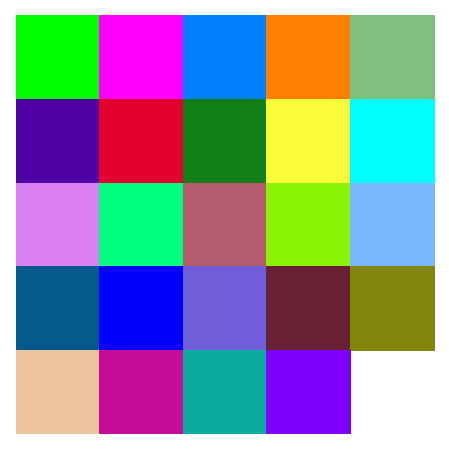

In [107]:
num_colors = len(df_stats['metric'].unique())
colors = distinctipy.get_colors(num_colors)
distinctipy.color_swatch(colors)

In [108]:
def rgb_to_hex(rgb):
    """
    Convert RGB tuple to hexadecimal color code.
    """
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))

In [109]:
metric_colors_dict = {m : rgb_to_hex(colors[idx]) for idx, m in enumerate(df_stats['metric'].unique())}

In [110]:
# resource: https://malouche.github.io/notebooks/scatter_bokeh2.html
from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.models import Panel, Tabs
from bokeh.plotting import output_file, save

import pandas as pd
import math

tabs = []

bokeh_data_dict = {}

bokeh_data_dict['METRIC COMPARISON: UNFILTERED'] = df_stats

filter_cols = [col for col in list(df_stats.columns) if isinstance(df_stats[col].values[0], (int, float, np.int64, np.float64))]

bokeh_data_dict['METRIC COMPARISON: FILTERED (10 < mean_cluster_size < 40) (10 < median_cluster_size < 40)'] = df_stats.loc[
    # (df_stats['metric'] == 'cosine') &
    # (df_stats['nns'] == 3) & 
    # (df_stats['parameter'] == 0.405) & 

    (df_stats['mean_cluster_size'] > 10) &
    (df_stats['median_cluster_size'] > 10) &
    (df_stats['mean_cluster_size'] < 40) &
    (df_stats['median_cluster_size'] < 40) &
    # (df_stats['nenriched_cluster_genes'] > 7000) &
    # (df_stats['modularity'] > 0.4) &

    (df_stats['dimensionality'] == 'baseline') &
    (df_stats['graph'] == 'umap_fuzzy_simplicial_set') &
    (df_stats['clustering'] == 'leiden_cpm') &
    (df_stats['partition_type'] == 'EXP')
]

bokeh_x = 'modularity'
bokeh_y = 'nenriched_clusters'
# bokeh_y = 'fraction_clusters_enriched'
color_column = 'metric'  # Column to use for coloring the points

axis_padding = 0.05
x_min, x_max = math.floor(df_stats[bokeh_x].min()) - axis_padding * df_stats[bokeh_x].min(), math.ceil(df_stats[bokeh_x].max()) + axis_padding * df_stats[bokeh_x].max()
y_min, y_max = math.floor(df_stats[bokeh_y].min()) - axis_padding * df_stats[bokeh_y].min(), math.ceil(df_stats[bokeh_y].max()) + axis_padding * df_stats[bokeh_y].max()

# metric_colors_dict = {
#     'minkowski_5.0': '#fa0217',
#     'minkowski_3.0': '#fa029b',
#     'minkowski_2.0': '#bc02fa',
#     'clr': '#0207fa',
#     'cosine': '#02e1fa',
#     'minkowski_1.0': '#02fa28',
#     'manhattan': '#e9fa02',
#     'minkowski_0.5': '#fa9f02',
#     'euclidean': '#02fab8',
#     'minkowski_4.0': '#8bfa02'
# }

for tab_name, bokeh_df in bokeh_data_dict.items():

    p = figure(plot_width=1000, plot_height=800, title='HOVER OVER POINTS TO SHOW DATA. CLICK ON METRICS IN THE LEGEND TO HIDE THEM.', sizing_mode='stretch_both', x_range=(x_min, x_max), y_range=(y_min, y_max))

    for val in sorted(bokeh_df[color_column].unique()):
        col_df=bokeh_df.loc[(bokeh_df[color_column]==val)]
        p.scatter(bokeh_x, bokeh_y, size=3, color=metric_colors_dict[val], legend_label=val, source=col_df)

    hover = HoverTool(tooltips=[
        ('Partition Type', '@partition_type'),
        ('Dimensionality', '@dimensionality'),
        ('Metric', '@metric'),
        ('Graph', '@graph'),
        ('Nearest Neighbors', '@nns'),
        ('Clustering', '@clustering'),
        ('Parameter', '@parameter'),
        ('Silhouette Score', '@silhouette_score'),
        ('Modularity', '@modularity'),
        ('Number of Clusters', '@nclusters'),
        ('Mean Cluster Size', '@mean_cluster_size'),
        ('Median Cluster Size', '@median_cluster_size'),
        ('Standard Deviation of Cluster Size', '@sd_cluster_size'),
        ('Number of Enriched Clusters', '@nenriched_clusters'),
        ('Mean Enriched Cluster Size', '@mean_enriched_cluster_size'),
        ('Median Enriched Cluster Size', '@median_enriched_cluster_size'),
        ('Standard Deviation of Enriched Cluster Size', '@sd_enriched_cluster_size'),
        ('Number of Enriched Cluster Genes', '@nenriched_cluster_genes'),
        ('Fraction of Clusters Enriched', '@fraction_clusters_enriched'),
    ])
    p.add_tools(hover)

    p.legend.click_policy="hide"
    p.legend.location = "bottom_left"

    p.xaxis.axis_label = bokeh_x
    p.yaxis.axis_label = bokeh_y

    p.min_border = 100

    tabs.append(Panel(child=p, title=tab_name))

plot_tabs1 = [t for t in tabs]


In [111]:
# resource: https://malouche.github.io/notebooks/scatter_bokeh2.html
from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.models import Panel, Tabs, RangeSlider, CustomJS, Column, Row, ColumnDataSource, CategoricalColorMapper, Legend

from bokeh.plotting import output_file, save

import pandas as pd
import math

tabs = []

bokeh_data_dict = {}

bokeh_data_dict['DYNAMIC FILTERING: UNFILTERED'] = df_stats

filter_cols = [col for col in list(df_stats.columns) if isinstance(df_stats[col].values[0], (int, float, np.int64, np.float64))]

bokeh_data_dict['DYNAMIC FILTERING: FILTERED (10 < mean_cluster_size < 40) (10 < median_cluster_size < 40)'] = df_stats.loc[
    # (df_stats['metric'] == 'cosine') &
    # (df_stats['nns'] == 3) & 
    # (df_stats['parameter'] == 0.405) & 

    (df_stats['mean_cluster_size'] > 10) &
    (df_stats['median_cluster_size'] > 10) &
    (df_stats['mean_cluster_size'] < 40) &
    (df_stats['median_cluster_size'] < 40) &
    # (df_stats['nenriched_cluster_genes'] > 7000) &
    # (df_stats['modularity'] > 0.4) &

    (df_stats['dimensionality'] == 'baseline') &
    (df_stats['graph'] == 'umap_fuzzy_simplicial_set') &
    (df_stats['clustering'] == 'leiden_cpm') &
    (df_stats['partition_type'] == 'EXP')
]

bokeh_x = 'modularity'
bokeh_y = 'nenriched_clusters'
# bokeh_y = 'fraction_clusters_enriched'
color_column = 'metric'  # Column to use for coloring the points

axis_padding = 0.05
x_min, x_max = math.floor(df_stats[bokeh_x].min()) - axis_padding * df_stats[bokeh_x].min(), math.ceil(df_stats[bokeh_x].max()) + axis_padding * df_stats[bokeh_x].max()
y_min, y_max = math.floor(df_stats[bokeh_y].min()) - axis_padding * df_stats[bokeh_y].min(), math.ceil(df_stats[bokeh_y].max()) + axis_padding * df_stats[bokeh_y].max()

# metric_colors_dict = {
#     'minkowski_5.0': '#fa0217',
#     'minkowski_3.0': '#fa029b',
#     'minkowski_2.0': '#bc02fa',
#     'clr': '#0207fa',
#     'cosine': '#02e1fa',
#     'minkowski_1.0': '#02fa28',
#     'manhattan': '#e9fa02',
#     'minkowski_0.5': '#fa9f02',
#     'euclidean': '#02fab8',
#     'minkowski_4.0': '#8bfa02'
# }

color_mapper = CategoricalColorMapper(factors=list(metric_colors_dict.keys()), palette=list(metric_colors_dict.values()))

for tab_name, bokeh_df in bokeh_data_dict.items():

    bokeh_data_source = ColumnDataSource(bokeh_df)

    sliders = {}

    for variable in filter_cols:
        sliders[variable] = RangeSlider(start=bokeh_df[variable].min(),
                                            end=bokeh_df[variable].max(),
                                            value=(bokeh_df[variable].min(), bokeh_df[variable].max()),
                                            step=smallest_unit(bokeh_df[variable].max()),
                                            title=f"{variable} range")


    p = figure(plot_width=1000, plot_height=800, title='HOVER OVER POINTS TO SHOW DATA. USE THE SLIDERS TO FILTER THE PARTITIONS.', sizing_mode='stretch_both', x_range=(x_min, x_max), y_range=(y_min, y_max))

    p.circle(
            x=bokeh_x,
            y=bokeh_y,
            source=bokeh_data_source,
            color={'field': color_column, 'transform': color_mapper},
            size=5,
            alpha=1,
            line_color='black'
        )

    callback = CustomJS(args=dict(source=bokeh_data_source, sliders=sliders), code="""
        const data = source.data;
        const indices = [];
        const variables = Object.keys(sliders);
        
        for (let i = 0; i < data['index'].length; i++) {
            let include = true;
            
            for (const variable of variables) {
                const slider_range = sliders[variable].value;
                const value = data[variable][i];
                
                if (value < slider_range[0] || value > slider_range[1]) {
                    include = false;
                    break;
                }
            }
            
            if (include) {
                indices.push(i);
            }
        }
        
        source.selected.indices = indices;
        source.change.emit();
    """)

    # Attach the callback to all sliders
    for slider in sliders.values():
        slider.js_on_change('value', callback)

    # Add all sliders to a layout
    slider_layout = Column(*sliders.values())

    hover = HoverTool(tooltips=[
        ('Partition Type', '@partition_type'),
        ('Dimensionality', '@dimensionality'),
        ('Metric', '@metric'),
        ('Graph', '@graph'),
        ('Nearest Neighbors', '@nns'),
        ('Clustering', '@clustering'),
        ('Parameter', '@parameter'),
        ('Silhouette Score', '@silhouette_score'),
        ('Modularity', '@modularity'),
        ('Number of Clusters', '@nclusters'),
        ('Mean Cluster Size', '@mean_cluster_size'),
        ('Median Cluster Size', '@median_cluster_size'),
        ('Standard Deviation of Cluster Size', '@sd_cluster_size'),
        ('Number of Enriched Clusters', '@nenriched_clusters'),
        ('Mean Enriched Cluster Size', '@mean_enriched_cluster_size'),
        ('Median Enriched Cluster Size', '@median_enriched_cluster_size'),
        ('Standard Deviation of Enriched Cluster Size', '@sd_enriched_cluster_size'),
        ('Number of Enriched Cluster Genes', '@nenriched_cluster_genes'),
        ('Fraction of Clusters Enriched', '@fraction_clusters_enriched'),
    ])
    p.add_tools(hover)

    # p.legend.click_policy="hide"
    # p.legend.location = "bottom_left"

    p.xaxis.axis_label = bokeh_x
    p.yaxis.axis_label = bokeh_y

    p.min_border = 100

    slider_layout.margin = 100

    layout = Row(p, slider_layout)

    tabs.append(Panel(child=layout, title=tab_name))

plot_tabs2 = [t for t in tabs]

# FIXME add filtering
# https://docs.bokeh.org/en/latest/docs/user_guide/basic/data.html#customjsfilter

In [112]:
tabbed_plot = Tabs(tabs=(plot_tabs1 + plot_tabs2))

output_file('./clustering_analysis.html')

save(tabbed_plot)

show(tabbed_plot)

In [15]:
df_stats

,partition_type,dimensionality,metric,graph,nns,clustering,parameter,silhouette_score,modularity,nclusters,mean_cluster_size,median_cluster_size,sd_cluster_size,nenriched_clusters,mean_enriched_cluster_size,median_enriched_cluster_size,sd_enriched_cluster_size,nenriched_cluster_genes,datetime,fraction_clusters_enriched
0,EXP,baseline,minkowski_0.5,umap_fuzzy_simplicial_set,10,leiden_cpm,0.005,0.028616,0.545982,159,120.452830,115.0,63.212400,106,127.603774,128.5,67.119111,13526,2024-04-01 14:33:23.516598,0.666667
1,EXP,baseline,minkowski_0.5,umap_fuzzy_simplicial_set,10,leiden_cpm,0.010,0.025876,0.482861,304,63.000000,57.0,32.481675,162,67.611111,61.5,33.481015,10953,2024-04-01 14:33:23.516598,0.532895
2,EXP,baseline,minkowski_0.5,umap_fuzzy_simplicial_set,10,leiden_cpm,0.015,0.023663,0.447783,444,43.135135,38.0,23.291237,178,49.983146,46.5,25.332280,8897,2024-04-01 14:33:23.516598,0.400901
3,EXP,baseline,minkowski_0.5,umap_fuzzy_simplicial_set,10,leiden_cpm,0.020,0.020545,0.421880,578,33.134948,30.0,17.868584,212,37.735849,37.5,17.937155,8000,2024-04-01 14:33:23.516598,0.366782
4,EXP,baseline,minkowski_0.5,umap_fuzzy_simplicial_set,10,leiden_cpm,0.025,0.021372,0.400608,699,27.399142,25.0,14.349392,234,31.145299,29.0,14.499788,7288,2024-04-01 14:33:23.516598,0.334764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58075,EXP,baseline,l1,umap_fuzzy_simplicial_set,4,leiden_cpm,1.080,0.032283,0.206215,10757,1.780422,2.0,0.658703,395,2.432911,2.0,0.580205,961,2024-04-04 12:57:36.180903,0.036720
58076,EXP,baseline,l1,umap_fuzzy_simplicial_set,4,leiden_cpm,1.085,0.031976,0.205519,10775,1.777448,2.0,0.657374,393,2.427481,2.0,0.579952,954,2024-04-04 12:57:36.180903,0.036473
58077,EXP,baseline,l1,umap_fuzzy_simplicial_set,4,leiden_cpm,1.090,0.032039,0.205287,10779,1.776788,2.0,0.656308,393,2.427481,2.0,0.579952,954,2024-04-04 12:57:36.180903,0.036460
58078,EXP,baseline,l1,umap_fuzzy_simplicial_set,4,leiden_cpm,1.095,0.031826,0.204717,10795,1.774155,2.0,0.655429,393,2.432570,2.0,0.584932,956,2024-04-04 12:57:36.180903,0.036406


In [ ]:
df_stats.drop_duplicates(subset=df_stats.columns.difference(['datetime']), inplace=True)

In [5]:
dataframe_utils.sql_query_df({name: globals()[name] for name in ['df_stats']}, 'select max(parameter) from df_stats')

,max(parameter)
0,1.1


In [ ]:
dataframe_utils.sql_query_df({'scan_stats_df': df_stats}, 'select min(parameter) from scan_stats_df')

In [ ]:
dataframe_utils.sql_query_df({'scan_stats_df': df_stats}, 'select count(distinct parameter) from scan_stats_df')

In [ ]:
def compute_num_clusters_fraction_of_genes_enriched(row):
    return row['nenriched_clusters'] * (row['nenriched_cluster_genes'] / 20326)

In [ ]:
df_stats['num_clusters_fraction_of_genes_enriched'] = df_stats.apply(compute_num_clusters_fraction_of_genes_enriched, axis=1)

In [ ]:
df_stats

In [ ]:
19 * (19933/20326)

# DISTANCE METRIC COMPARISON

In [ ]:
num_colors = len(df_stats['metric'].unique())
colors = distinctipy.get_colors(num_colors)
distinctipy.color_swatch(colors)

In [ ]:
plt.figure(figsize=(40, 40))

color_dict = {} 

for idx, m in enumerate(df_stats['metric'].unique()):
    for p in sorted(df_stats['parameter'].unique()):
        df = df_stats.loc[
            (df_stats['parameter'] == p) & 
            (df_stats['dimensionality'] == 'baseline') &
            (df_stats['graph'] == 'umap_fuzzy_simplicial_set') &
            (df_stats['clustering'] == 'leiden_cpm') &
            (df_stats['metric'] == m)
        ]

        y = 'nenriched_clusters'
        # y = 'num_clusters_fraction_of_genes_enriched'

        # x = 'silhouette_score'
        x = 'modularity'

        # plt.plot(df[x].values, df[y].values, label=f'{p}', color=colors[idx])
        plt.scatter(df[x].values, df[y].values, label=f'{p}', color=colors[idx], s=5)


    color_dict[m] = colors[idx]  

plt.xlabel(x, fontsize=40)
plt.ylabel(y, fontsize=40)
plt.title(f'{y} VS. {x}', fontsize=40)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[m], markersize=10) for m in color_dict]
plt.legend(handles, color_dict.keys(), title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=40)

plt.show()

In [ ]:
df_stats.loc[
    (df_stats['mean_cluster_size'] > 9) & 
    (df_stats['mean_cluster_size'] < 30) &
    (df_stats['median_cluster_size'] > 9) & 
    (df_stats['median_cluster_size'] < 30)
    ]

In [ ]:
df_stats_true = df_stats.loc[df_stats['partition_type'] == 'EXP']
df_stats_neg_ctrl = df_stats.loc[~(df_stats['partition_type'] == 'EXP')]

In [ ]:
df_stats_true

In [ ]:
df_stats_neg_ctrl

In [ ]:
df_true_cluster = df_stats_true.loc[
    (df_stats_true['nns'] == 10) & 
    (df_stats_true['parameter'] == 0.0105) & 

    (df_stats_true['dimensionality'] == 'baseline') &
    (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set') &
    (df_stats_true['clustering'] == 'leiden_cpm') &
    (df_stats_true['metric'] == plotting_metric) 
]

In [ ]:
df_neg_ctrls = df_stats_neg_ctrl.loc[
    (df_stats_neg_ctrl['nns'] == 10) & 
    (df_stats_neg_ctrl['parameter'] == 0.0105) & 

    (df_stats_neg_ctrl['dimensionality'] == 'baseline') &
    (df_stats_neg_ctrl['graph'] == 'umap_fuzzy_simplicial_set') &
    (df_stats_neg_ctrl['clustering'] == 'leiden_cpm') &
    (df_stats_neg_ctrl['metric'] == plotting_metric) 
]

In [ ]:
df_true_cluster

In [ ]:
df_neg_ctrls

In [ ]:
hist_clustering_metric = 'silhouette_score'
# hist_clustering_metric = 'modularity'

hist_data = df_neg_ctrls[hist_clustering_metric].values
hist_data

In [ ]:
# hist_line_at_x = df_true_cluster[hist_clustering_metric].values[0]
# hist_line_at_x

In [ ]:
# # Create the histogram
# plt.hist(hist_data, bins=30, edgecolor='black')

# # Add a vertical line at the specified x value
# plt.axvline(x=hist_line_at_x, color='red', linestyle='dashed', linewidth=2, label='experimental at x={}'.format(round(hist_line_at_x, 2)))

# # Add labels and title
# plt.xlabel(hist_clustering_metric)
# plt.ylabel('frequency')
# plt.title(f'{len(hist_data)} neg. controls vs. experimental {hist_clustering_metric} distribution')

# plt.legend()

# # Show the plot
# plt.show()

In [ ]:
df_stats_true['silhouette_score'].mean()

In [ ]:
df_stats_true['silhouette_score'].median()

In [ ]:
df_stats_true['silhouette_score'].max()

In [ ]:
df_stats_true['modularity'].mean()

In [ ]:
df_stats_neg_ctrl['silhouette_score'].mean()

In [ ]:
df_stats_neg_ctrl['silhouette_score'].median()

In [ ]:
df_stats_neg_ctrl['silhouette_score'].max()

In [ ]:
df_stats_neg_ctrl['modularity'].mean()

In [ ]:
df_stats_neg_ctrl['modularity'].median()

In [ ]:
df_stats_true['nns'].unique()

In [ ]:
df_stats_true['parameter'].unique()

In [ ]:
df_stats_true['parameter'].min()

In [ ]:
df_stats_true.loc[df_stats_true['modularity'] > 0.8]

In [ ]:
df_stats_true.loc[(df_stats_true['silhouette_score'] > 0.04) & (df_stats_true['nclusters'] > 100)]

In [ ]:
df_stats_true.loc[df_stats_true['nclusters'] < 10]

In [ ]:
df_stats_true.loc[(df_stats_true['metric'] != 'manhattan') & (df_stats_true['metric'] != 'euclidean')]

In [ ]:
df_stats_true.loc[(df_stats_true['metric'] != 'cosine') & (df_stats_true['metric'] != 'euclidean') & (df_stats_true['nns'] == 12) & (df_stats_true['parameter'] == 0.095)]

In [ ]:
df_stats_true.loc[(df_stats_true['metric'] != 'manhattan') & (df_stats_true['metric'] != 'euclidean')]

In [ ]:
for p in (df_stats_true['parameter'].unique()):
    pdf = df_stats_true.loc[df_stats_true['parameter'] == p]
    max_pdf = pdf.loc[pdf['silhouette_score'] == pdf['silhouette_score'].max()]
    print(max_pdf[['nns', 'silhouette_score', 'nclusters']])

In [ ]:
# Create an empty DataFrame to store the results
best_nn_df = pd.DataFrame(columns=['parameter', 'nns', 'silhouette_score', 'nclusters'])

# Iterate over unique parameters
for p in df_stats_true['parameter'].unique():
    pdf = df_stats_true.loc[df_stats_true['parameter'] == p]
    
    # Find the row with the maximum silhouette_score
    max_pdf = pdf.loc[pdf['silhouette_score'].idxmax()]
    
    # Append the relevant information to the result DataFrame
    best_nn_df = best_nn_df.append({'parameter': p, 'nns': max_pdf['nns'],
                                  'silhouette_score': max_pdf['silhouette_score'],
                                  'nclusters': max_pdf['nclusters'],
                                  'nenriched_clusters': max_pdf['nenriched_clusters'],
                                  'nenriched_cluster_genes': max_pdf['nenriched_cluster_genes']
                                  }, ignore_index=True)
    

best_nn_df[best_nn_df['nclusters'] > 50]

# CONSTRAINED NN PLOTTING PARAMETERS

In [ ]:
# PLOTTING PARAMETERS
df = df_stats_true.loc[
    (df_stats_true['nns'] == 6) & 
    # (df_stats_true['parameter'] == 0.0005) & 

    (df_stats_true['dimensionality'] == 'baseline') &
    (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set') &
    (df_stats_true['clustering'] == 'leiden_cpm') &
    (df_stats_true['metric'] == plotting_metric) &
    (df_stats_true['nclusters'] > 50)
]

df

In [ ]:
df = df_stats.loc[
    (df_stats['nns'] > 4) & 
    (df_stats['nns'] < 6) & 
    (df_stats['parameter'] > 0.034) & 
    (df_stats['parameter'] < 0.036) &


    (df_stats['dimensionality'] == 'baseline') &
    (df_stats['graph'] == 'umap_fuzzy_simplicial_set') &
    (df_stats['clustering'] == 'leiden_cpm') &
    (df_stats['metric'] == 'manhattan')
]

In [ ]:
df_optimal = df_stats_true.loc[
    (df_stats_true['dimensionality'] == 'baseline')
    & (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set')
    & (df_stats_true['clustering'] == 'leiden_cpm') 
    & (df_stats_true['metric'] == plotting_metric) 
    # & (df_stats_true['nenriched_cluster_genes'] > 5000) 
    # & (df_stats_true['nenriched_cluster_genes'] < 6000) 
    # & (df_stats_true['nclusters'] > 1000)
    # & (df_stats_true['nclusters'] < 1300)
    & (df_stats_true['nenriched_clusters'] > 350)
    # & (df_stats_true['modularity'] > 0.5)
    & (df_stats_true['mean_cluster_size'] < 50)
    & (df_stats_true['median_cluster_size'] < 50)
    & (df_stats_true['mean_enriched_cluster_size'] < 50)
    & (df_stats_true['median_enriched_cluster_size'] < 50)
    & (df_stats_true['mean_cluster_size'] > 10)
    & (df_stats_true['median_cluster_size'] > 10)
    & (df_stats_true['mean_enriched_cluster_size'] > 10)
    & (df_stats_true['median_enriched_cluster_size'] > 10)
].sort_values(by=['modularity', 'silhouette_score'], ascending=False)
df_optimal

In [ ]:
plt.plot(df_optimal['modularity'].values, df_optimal['silhouette_score'].values)
plt.show()

In [ ]:
plt.plot(df_stats_true['modularity'].values, df_stats_true['silhouette_score'].values)
plt.show()

In [ ]:
df_stats_true.loc[
    (df_stats_true['dimensionality'] == 'baseline')
    & (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set')
    & (df_stats_true['clustering'] == 'leiden_cpm') 
    & (df_stats_true['metric'] == plotting_metric) 
    & (df_stats_true['nclusters'] > 1000)
    & (df_stats_true['nclusters'] < 1300)
]

In [ ]:
df_stats_true.loc[
    (df_stats_true['num_clusters_fraction_of_genes_enriched'] == df_stats_true['num_clusters_fraction_of_genes_enriched'].max())
]

In [ ]:
df_stats_true.loc[
    (df_stats_true['nenriched_cluster_genes'] == df_stats_true['nenriched_cluster_genes'].max())
]

# Upper limit of nenriched_cluster_genes: 10247/19152 genes 53.50%
# (2021) 6625 genes (32.59%)

In [ ]:
df.loc[df['nenriched_clusters']==df['nenriched_clusters'].max()]

In [ ]:
# 8NN local maxs (sklearn NN)
df.loc[
    (df['parameter']==0.950)
    | (df['parameter']==0.755)
    | (df['parameter']==0.530)
    | (df['parameter']==0.370)
    | (df['parameter']==0.225)
    | (df['parameter']==0.115)
    | (df['parameter']==0.045)
    | (df['parameter']==0.020)
    ]

In [ ]:
# 10NN local maxs (sklearn NN)
df.loc[
    (df['parameter']==0.1)
    ]

In [ ]:
# 2NN local maxs
df.loc[
    (df['parameter']==0.280)
    ]

In [ ]:
# 3NN local maxs
df.loc[
    (df['parameter']==0.900)
    | (df['parameter']==0.605)
    | (df['parameter']==0.536)
    | (df['parameter']==0.485)
    | (df['parameter']==0.340)
    | (df['parameter']==0.075)
    ]

In [ ]:
# 5NN local maxs
df.loc[
    (df['parameter']==0.935)
    | (df['parameter']==0.795)
    | (df['parameter']==0.640)
    | (df['parameter']==0.465)
    | (df['parameter']==0.350)
    | (df['parameter']==0.295)
    | (df['parameter']==0.190)
    | (df['parameter']==0.125)
    | (df['parameter']==0.0499999999999999)
    | (df['parameter']==0.0349999999999999)
    ]

In [ ]:
# 6NN local maxs
df.loc[
    (df['parameter']==0.800)
    | (df['parameter']==0.665)
    | (df['parameter']==0.435)
    | (df['parameter']==0.045)
    ]

In [ ]:
y = 'nenriched_clusters'
# y = 'num_clusters_fraction_of_genes_enriched'

# x = 'silhouette_score'
x = 'modularity'

labels = 'parameter'
# labels = 'nns'

In [ ]:
x_in = 50
y_in = 50
# x_in = 15
# y_in = 10
plt.figure(figsize=(x_in, y_in))

# Create scatter plot
plt.scatter(df[x].values, df[y].values)

label_adj_x = (0
            + (df[x].max() - df[x].min()) * 0.0075
            # + x_in/6.4
                )
label_adj_y = (0 
            # + (y_in/4.8)
               )

# Label each point with the number of nearest neighbors below the point
for i, txt in enumerate(df[labels].values):
    plt.text(df[x].values[i] + label_adj_x, df[y].values[i] + label_adj_y, 
            str("{:.3f}".format(
                txt
                ))
                ,
            fontsize=8, ha='center', va='top', color='black')

# Set axis labels and title
plt.xlabel(x)
plt.ylabel(y)
plt.title(f'{y} VS. {x} for varying {labels}')

# Display the plot
plt.show()

In [ ]:
df_stats_true['parameter'].unique()

# NN CURVES FOR VARYING RP PLOTTING PARAMETERS

In [ ]:
plot_ps = sorted(df_stats_true['parameter'].unique())

# FOR FINER STEP SCAN
if df_stats_true.loc[(df_stats_true['metric'] == plotting_metric)].shape[0] > 200:
    plot_ps = []
    for p_idx in np.arange(19, len(df_stats_true['parameter'].unique()), 20):
        plot_ps.append(sorted(df_stats_true['parameter'].unique())[p_idx])

In [ ]:
import distinctipy

num_colors = len(df_stats_true['parameter'].unique())

colors = distinctipy.get_colors(num_colors)

In [ ]:
plt.figure(figsize=(20, 20))

for idx, p in enumerate(plot_ps):
    df = df_stats_true.loc[
        # (df_stats_true['nns'] == 6) & 
        (df_stats_true['parameter'] == p) & 

        (df_stats_true['dimensionality'] == 'baseline') &
        (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set') &
        (df_stats_true['clustering'] == 'leiden_cpm') &
        (df_stats_true['metric'] == plotting_metric) &
        (df_stats_true['nclusters'] > 50)
    ]

    y = 'nenriched_clusters'
    # y = 'num_clusters_fraction_of_genes_enriched'

    # x = 'silhouette_score'
    x = 'modularity'

    plt.plot(df[x].values, df[y].values, label=str(p), color=colors[idx])

# Set axis labels and title
plt.xlabel(x)
plt.ylabel(y)
plt.title(f'{y} VS. {x}')

# Display the plot
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20, 20))

for idx, p in enumerate(plot_ps):
    df = df_stats_true.loc[
        # (df_stats_true['nns'] == 6) & 
        (df_stats_true['parameter'] == p) & 

        (df_stats_true['dimensionality'] == 'baseline') &
        (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set') &
        (df_stats_true['clustering'] == 'leiden_cpm') &
        (df_stats_true['metric'] == plotting_metric) &
        (df_stats_true['nclusters'] > 50)
    ]

    y = 'nenriched_cluster_genes'
    # y = 'num_clusters_fraction_of_genes_enriched'

    # x = 'silhouette_score'
    x = 'modularity'

    plt.plot(df[x].values, df[y].values, label=str(p), color=colors[idx])

# Set axis labels and title
plt.xlabel(x)
plt.ylabel(y)
plt.title(f'{y} VS. {x}')

# Display the plot
plt.legend()
plt.show()

In [ ]:
df_stats_true.loc[
        (df_stats_true['nns'] == 3) & 
        (df_stats_true['parameter'] == 0.5) & 
        (df_stats_true['dimensionality'] == 'baseline') &
        (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set') &
        (df_stats_true['clustering'] == 'leiden_cpm') &
        (df_stats_true['metric'] == 'cosine') &
        (df_stats_true['nclusters'] > 50)
    ]

In [ ]:
df_stats_true.loc[
        (df_stats_true['nns'] == 3) & 
        (df_stats_true['parameter'] == 0.21) & 
        (df_stats_true['dimensionality'] == 'baseline') &
        (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set') &
        (df_stats_true['clustering'] == 'leiden_cpm') &
        (df_stats_true['metric'] == 'cosine') &
        (df_stats_true['nclusters'] > 50)
    ]

In [ ]:
df_stats_true.loc[
        (df_stats_true['nns'] == 3) & 
        (df_stats_true['parameter'] == 0.405) & 
        (df_stats_true['dimensionality'] == 'baseline') &
        (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set') &
        (df_stats_true['clustering'] == 'leiden_cpm') &
        (df_stats_true['metric'] == 'cosine') &
        (df_stats_true['nclusters'] > 50)
    ]

In [ ]:
df_stats_true.loc[
        # (df_stats_true['nns'] == 3) & 
        # (df_stats_true['parameter'] == 0.405) & 
        (df_stats_true['dimensionality'] == 'baseline') &
        (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set') &
        (df_stats_true['clustering'] == 'leiden_cpm') &
        (df_stats_true['metric'] == 'cosine') &
        (df_stats_true['mean_cluster_size'] > 10) &
        (df_stats_true['median_cluster_size'] > 10) &
        (df_stats_true['mean_cluster_size'] < 30) &
        (df_stats_true['median_cluster_size'] < 30) &
        (df_stats_true['nenriched_cluster_genes'] > 7000) &
        (df_stats_true['modularity'] > 0.4)
    ]

In [ ]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

for idx, p in enumerate(plot_ps):
    df = df_stats_true.loc[
        # (df_stats_true['nns'] == 6) & 
        (df_stats_true['parameter'] == p) & 
        (df_stats_true['dimensionality'] == 'baseline') &
        (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set') &
        (df_stats_true['clustering'] == 'leiden_cpm') &
        (df_stats_true['metric'] == plotting_metric) &
        (df_stats_true['nclusters'] > 50)
    ]

    y = 'nenriched_clusters'
    x = 'modularity'
    z = 'nenriched_cluster_genes'

    ax.plot(df[x].values, df[y].values, df[z].values, label=str(p), color=colors[idx])

# Set axis labels and title
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
plt.title(f'{y} VS. {x} VS. {z}')

# Display the plot
plt.legend()
plt.show()

# NN SCATTER FOR VARYING RP PLOTTING PARAMETERS

In [ ]:
for p in sorted(df_stats_true['parameter'].unique()):
    df = df_stats_true.loc[
        # (df_stats_true['nns'] == 6) & 
        (df_stats_true['parameter'] == p) & 

        (df_stats_true['dimensionality'] == 'baseline') &
        (df_stats_true['graph'] == 'umap_fuzzy_simplicial_set') &
        (df_stats_true['clustering'] == 'leiden_cpm') &
        (df_stats_true['metric'] == plotting_metric) &
        (df_stats_true['nclusters'] > 50)
    ]

    y = 'nenriched_clusters'
    # y = 'num_clusters_fraction_of_genes_enriched'

    # x = 'silhouette_score'
    x = 'modularity'

    # labels = 'parameter'
    labels = 'nns'

    # Create scatter plot
    plt.scatter(df[x].values, df[y].values)

    label_adj = (df[x].max() - df[x].min()) * 0.03

    # Label each point with the number of nearest neighbors below the point
    for i, txt in enumerate(df[labels].values):
        plt.text(df[x].values[i] + label_adj, df[y].values[i], str(txt),
                fontsize=8, ha='center', va='top', color='black')

    # Set axis labels and title
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{y} VS. {x} for varying {labels}')

    # Display the plot
    print(p)
    plt.show()